# Imports:

In [5]:
import os
import numpy as np
from matplotlib import pyplot as plt

from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import load_img, img_to_array
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Conv2DTranspose, Input, Flatten, Dense, BatchNormalization, Reshape

In [7]:
def get_images(directory, image_size):
    """Read all images """
    files = os.listdir(directory)
    img_list = []

    for file_name in files:
        if file_name.endswith(".png"):
            img_path = directory + file_name
            img = load_img(img_path, target_size=(image_size))
            img = img_to_array(img, dtype='float32')
            img_list.append(img)
    
    return np.array(img_list)

def rotate_images(images_to_rotate):
    rotation_list = []
    type(rotation_list)
    for i in range(3):
        rotated_images = []
        for img in images_to_rotate:
            rot_img = np.rot90(img)
            rotated_images.append(rot_img)
        
        rotated_images = np.array(rotated_images)
        images_to_rotate = rotated_images
        rotation_list.append(rotated_images)
        
    return rotation_list[0], rotation_list[1], rotation_list[2]

def normalize(array):
    """Normalizes the supplied array of images."""
    array = array.astype("float32") / 255.0
    return array

def add_noise(array):
    """Adds random noise to each image in the supplied array."""
    noise_factor = 0.2
    noisy_array = array + noise_factor * np.random.normal(
        loc=0.0, scale=1.0, size=array.shape
    )

    return np.clip(noisy_array, 0.0, 1.0)

def display(array1, array2, n):
    """Displays n random images from each array."""
    indices = np.random.randint(len(array1), size=n)
    if n == len(array1):
        images1 = array1
        images2 = array2
    else:
        images1 = array1[indices, :]
        images2 = array2[indices, :]
    
    for i, (image1, image2) in enumerate(zip(images1, images2)):
        ax = plt.subplot(3, n, i + 1)
        plt.imshow(image1)
        
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        ax = plt.subplot(3, n, i + 1 + n)
        plt.imshow(image2)
        
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        
    plt.show()

def build_autoencoder(image_size):
    encoder_input = Input(shape=(image_size[0], image_size[1], 3))
    
    # Encoding layers
    x = Conv2D(32, (3, 3), activation="relu", padding="same")(encoder_input)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2), padding="same")(x)
    x = Conv2D(32, (3, 3), activation="relu", padding="same")(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2), padding="same")(x)
    x = Conv2D(32, (3, 3), activation="relu", padding="same")(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2), padding="same")(x)
    
    decoded_shape = x.shape[1:]
    print(decoded_shape)
    
    # Flatten layers
    x = Flatten()(x)
    flat_length = x.shape[1]
    print(flat_length)
    x = Dense(1024, activation="relu")(x)
    x = Dense(flat_length, activation="relu")(x)
    x = Reshape(decoded_shape)(x)
    
    # Decoding layers
    x = Conv2DTranspose(32, (3, 3), strides=2, activation="relu", padding="same")(x)
    x = Conv2DTranspose(32, (3, 3), strides=2, activation="relu", padding="same")(x)
    x = Conv2DTranspose(32, (3, 3), strides=2, activation="relu", padding="same")(x)
    x = Conv2D(3, (3, 3), activation="sigmoid", padding="same")(x)
    
    # Create and compile autoencoder
    autoencoder = Model(encoder_input, x)
    autoencoder.compile(optimizer="adam", loss="binary_crossentropy")
    
    return autoencoder

# Preprocessing images

(209, 128, 128, 3)
(209, 128, 128, 3)


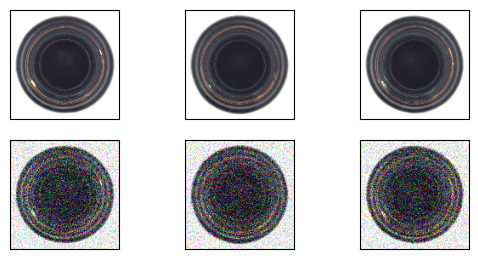

In [8]:
data_directory = "../dataset/bottle/train/good/"
broken_path = "../dataset/bottle/test/broken_large/000.png"

image_size = (128,128)

images = get_images(data_directory, image_size) # Read all images from data_directory
print(images.shape)
images = normalize(images)          # Normalize the pixel values from integer values [0, 255] to float [0, 1]
rotated_90, rotated_180, rotated_270 = rotate_images(images)
print(rotated_90.shape)
noisy_images = add_noise(images)    # Add noise to every images in images and store in a separate list


display(images, noisy_images, 3)

In [9]:
autoencoder = build_autoencoder(image_size)
autoencoder.summary()

(16, 16, 32)
8192


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 128, 128, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128, 128, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 64, 64, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 64, 64, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 32, 32, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1024)           │     8,389,632 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 8192)           │     8,396,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose                │ (None, 32, 32, 32)     │         9,248 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_1              │ (None, 64, 64, 32)     │         9,248 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_2              │ (None, 128, 128, 32)   │         9,248 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 128, 128, 3)    │           867 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,834,819 (64.22 MB)

 Trainable params: 16,834,627 (64.22 MB)

 Non-trainable params: 192 (768.00 B)

In [10]:
all_images = np.concatenate((images, rotated_90, rotated_180, rotated_270, noisy_images))
train, test = train_test_split(all_images, test_size=0.2)
print(train.shape)
print(test.shape)

(836, 128, 128, 3)
(209, 128, 128, 3)


In [11]:
autoencoder.fit(
    x=train,
    y=train,
    epochs=100,
    batch_size=64,
    shuffle=True,
    validation_split=0.2,
)

Epoch 1/100
 3/11 ━━━━━━━━━━━━━━━━━━━━ 18s 2s/step - loss: 0.6907

KeyboardInterrupt: 

In [ ]:
indices = np.random.randint(len(test), size=3)
small_test = test[indices, :].copy()
print(small_test.shape)
broken_img = load_img(broken_path, target_size=image_size)
broken_img = img_to_array(broken_img, dtype='float32')
broken_img = broken_img.astype("float32") / 255.0
print(broken_img.shape)
small_test = np.append(small_test, np.array([broken_img]), axis=0)
print(small_test.shape)
predictions = autoencoder.predict(small_test)

In [ ]:
display(small_test, predictions, 4)